In [92]:
import os
import numpy as np
from pyplr import utils
import pandas as pd
from classPLRfromGitHub import PLR
from pyplr import graphing
from pyplr import preproc
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import simpledialog
import sys
import importlib
import checkdata
from preprocessingCopy1 import ProcessConfig

In [58]:
# create a Tkinter window
root = tk.Tk()
root.withdraw()

# ask for subject id
subject_id = simpledialog.askstring(title="Subject ID",
                                    prompt="Enter subject ID:")


# Load the data from the pupil player
# Pupil Labs recording directory
# Load the CSV file

rec_dir = f"/Users/Katharina/Desktop/Beispieldaten/{subject_id[:4]}/{subject_id}/"
utils.print_file_structure(rec_dir)

/
    .DS_Store
    PLR_left_2d_results.csv
    PLR_right_2d_results.csv
    annotation_timestamps.npy
exports/
    .DS_Store
    000/
        annotations.csv
        export_info.csv
        gaze_positions.csv
        pupil_gaze_positions_info.txt
        pupil_positions.csv
        pupil_positions.csv.pickle
pyplr_analysis/


In [93]:
# define the patient ID for the dataframe and assign the 4 light strenghts
Light_strenght_1 = 1
Light_strenght_2 = 2
Light_strenght_3 = 3
Light_strenght_4 = 4



# Sampling frequency
SAMPLE_RATE = 120

# Columns to load
use_cols = ['confidence',
            'method',
            'pupil_timestamp',
            'eye_id',
            'diameter']

pupil_cols = ['diameter']

# Check if the pyplr_analysis directory exists
if not os.path.exists(os.path.join(rec_dir, 'pyplr_analysis')):
    # Create the directory if it doesn't exist
    os.makedirs(os.path.join(rec_dir, 'pyplr_analysis'))

# Get a handle on a subject
s = utils.new_subject(
    rec_dir, export='000', out_dir_nm='pyplr_analysis')


************************************************************
*****************************  *****************************
************************************************************


NameError: name 'eye0' is not defined

In [83]:
# Load pupil data, method has to be changed to '3d' otherwise multiple repeat error
#eye_id=best takes the eye with the best confidence, eye_id=0 takes right, 1 takes left
samples = utils.load_pupil(
    s['data_dir'], eye_id='left', method='2d', cols=use_cols)
samples

# load the pupil data for the current combination of eye_id and method
samples = utils.load_pupil(s['data_dir'], eye_id='left', method='2d', cols=use_cols)


Loaded 10365 samples
Loaded 10365 samples


In [94]:
importlib.reload(checkdata)

# Let's try to remove blinks and filter the result

#what=eye0[0]


# Iterate over the specified data frames


reconstruct(what)

def reconstruct(eye, window_size=100):
    # Remove blinks.
    eye['diameter_rec']=checkdata.blinkreconstruct(eye['diameter'], 
                                                   vt_start=10/600,vt_end=5/600, mode='advanced')
     # blinkreconstruct replaces the bliks with NaN with mode='advanced',
    # so we interpolate the gaps and low pass the result to obtain something. 
    eye['diameter_rec_interp']=eye['diameter_rec'].interpolate(method='linear')
     # Use moving average + recenter as low pass.
    eye['diameter_rec_interp_100']=eye['diameter_rec_interp'].rolling(window=window_size).mean().shift(-window_size//2)

plot_range = range(20)  # Indices of data frames to plot (0-19)


    # Iterate over the specified data frames
for i in plot_range:
    what = eye0[i]
    reconstruct(what)
    
    sub = what.plot(x='pupil_timestamp', y='diameter', kind='line')

    sub = what.plot(ax=sub, x='pupil_timestamp', y='diameter_rec_interp', kind='line')
    sub.set_title(f"Data Frame {i} - Original and Reconstructed Diameter")

    sub = what.plot(x='pupil_timestamp', y='diameter_rec_interp', kind='line')

    sub = what.plot(ax=sub, x='pupil_timestamp', y='diameter_rec_interp_100', kind='line')
    sub.set_title(f"Data Frame {i} - Reconstructed and Smoothed Diameter")

    what.plot(x='pupil_timestamp', y='diameter_rec_interp_100', kind='line')
    plt.title(f"Data Frame {i} - Smoothed Diameter")

    plt.show()



NameError: name 'reconstruct' is not defined

Loaded 4 events


,index,label,duration
timestamp,,,
9389.786341,754,LIGHT_ON,NaN
9404.971019,1207,LIGHT_ON,NaN
9420.186315,1661,LIGHT_ON,NaN
9435.370333,2114,LIGHT_ON,NaN


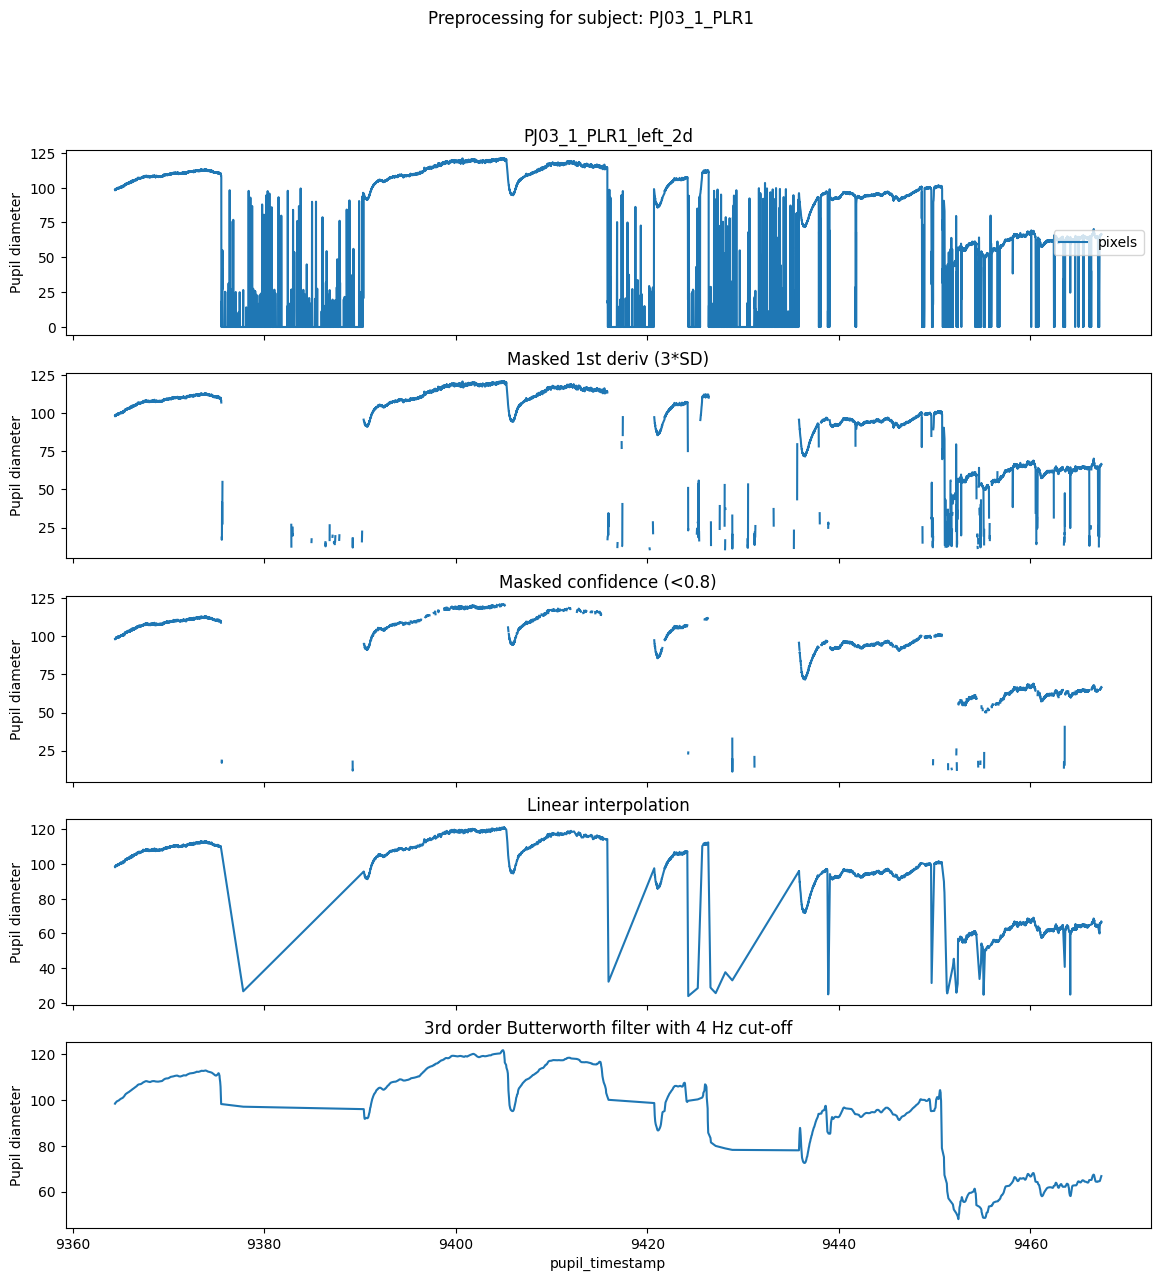

In [61]:
# Make figure for processing, append figure to pupil_preprocessing
f, axs = graphing.pupil_preprocessing_figure(nrows=5, subject=f"{subject_id}" )
# Plot the raw data
# Plot the raw data
samples[pupil_cols].plot(title=f"{subject_id}_left_2d", ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['pixels'])
# Mask first derivative
#Default is a threshold of 3 SD from the mean first derivate
# If there are a lot of blinks the mean first derivate is higher
# Therefore set the threshold lower 
samples = preproc.mask_pupil_first_derivative(
    samples, threshold=3.0, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples = preproc.mask_pupil_confidence(
    samples, threshold=0.8, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)
 
# Apply z-score filter to diameter_3d column
diameter_zscore = (samples['diameter'] - samples['diameter'].mean()) / samples['diameter'].std()
zscore_threshold = 3
samples = samples[abs(diameter_zscore) <= zscore_threshold]


# Interpolate
samples = preproc.interpolate_pupil(
    samples, interp_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples = preproc.butterworth_series(
    samples, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

events = utils.load_annotations(s['data_dir'])
events


In [62]:
# Number of samples to extract and which sample
# should mark the onset of the event
# 120 data points equal one second with a sample rate of 120 
# Real duration is Duration-ONSET_IDX, example 240 equals 1 second
#ONSET_IDX is the time before light stimulus that gets sampled 
DURATION = 1200
ONSET_IDX = 120

# Extract the event ranges, gets range of total duration (720) and shifts the onset_idx to the left in time, therefore 120 is the 0 point
ranges = utils.extract(
    samples,
    events,
    offset=-ONSET_IDX,
    duration=DURATION,
    borrow_attributes=['color'])

# Convert data to numeric format
ranges = ranges.apply(pd.to_numeric, errors='coerce')

# Calculate baselines, the time before the onset is 0 to 120
baselines = ranges.loc[:, range(0, ONSET_IDX), :].groupby(level=0, axis=1).mean()

# New columns for percent signal change, simply adds 2 new columns with percent change
ranges = preproc.percent_signal_change(
    ranges, baselines, pupil_cols)
ranges

print(ranges.loc[0:3])

ranges1 = ranges.loc[0]
ranges2 = ranges.loc[1]
ranges3 = ranges.loc[2]
ranges4 = ranges.loc[3]

print(ranges4)


Extracted ranges for 4 events
             eye_id  confidence    diameter  method  interpolated   
event onset                                                         
0     0           1    0.987654  112.703127     NaN             0  \
      1           1    0.911639  112.713885     NaN             0   
      2           1    0.936214  112.721948     NaN             0   
      3           1    0.822129  112.727197     NaN             0   
      4           1    0.826423  112.729619     NaN             0   
...             ...         ...         ...     ...           ...   
3     1195        1    1.000000   98.490574     NaN             0   
      1196        1    1.000000   98.580763     NaN             0   
      1197        1    1.000000   98.676409     NaN             0   
      1198        1    0.933092   98.776741     NaN             0   
      1199        1    0.857497   98.880885     NaN             0   

                orig_idx  color  diameter_pc  
event onset              

,value
Baseline,103.509182
Latency_a,0.258333
Latency_b,0.108333
T2MaxVel,2.150000
T2MaxCon,0.516667
T2Rec75pc,1.433333
PeakCon,72.450237
ConAmplitude,31.058945
VelConMax,134.285172
VelConAve,19.225377


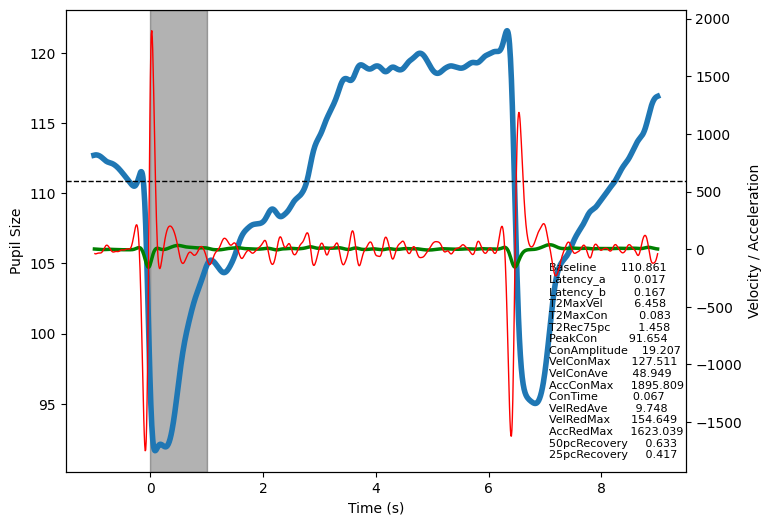

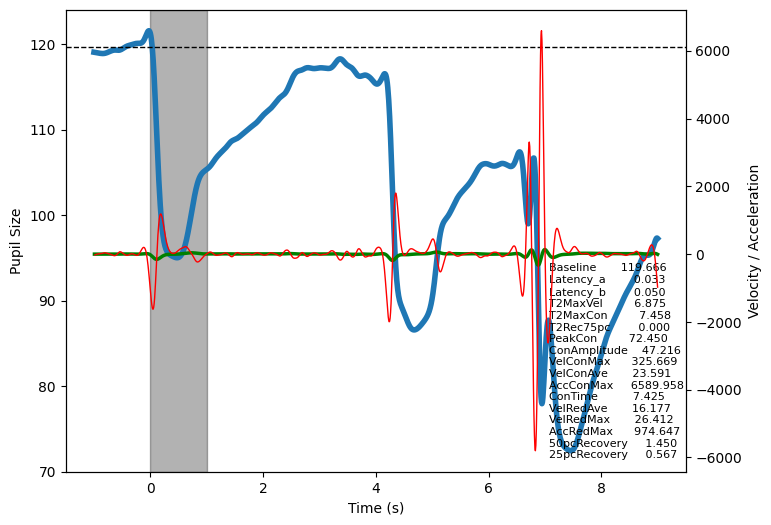

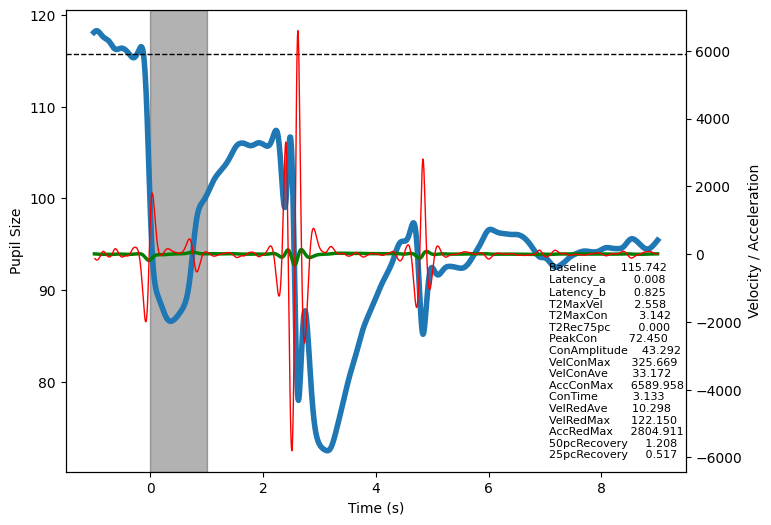

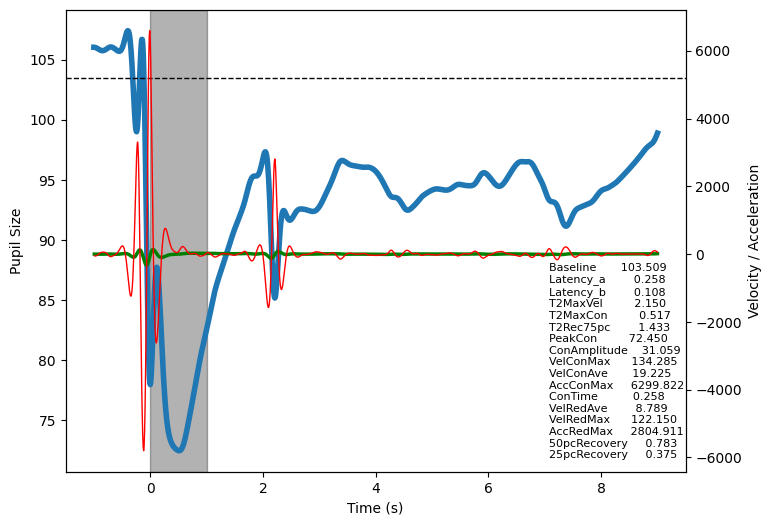

In [63]:
def get_average_plr(input_range):
    average_plr = input_range.groupby(level=0)['diameter'].mean().to_numpy()
    return PLR(average_plr,
              sample_rate=SAMPLE_RATE,
              onset_idx=ONSET_IDX,
              stim_duration=1)

plr1 = get_average_plr(ranges1)
plr2 = get_average_plr(ranges2)
plr3 = get_average_plr(ranges3)
plr4 = get_average_plr(ranges4)

plr_all = [plr1, plr2, plr3, plr4]


#plot graphs for vel = velocity in green, acc = acceleration in red and parameters
fig1 = plr1.plot(vel=True, acc=True, print_params=True)
fig2 = plr2.plot(vel=True, acc=True, print_params=True)
fig3 = plr3.plot(vel=True, acc=True, print_params=True)
fig4 = plr4.plot(vel=True, acc=True, print_params=True)

params1 = plr1.parameters()
params1

params2 = plr2.parameters()
params2

params3 = plr3.parameters()
params3

params4 = plr4.parameters()
params4



In [64]:
def get_pyplr_results(plr):
#D1 = baseline pupilsize, in mm
    D1 = plr.baseline()
    print("D1: ",D1)
    
    #D2 = minimum pupilsize, in mm 
    D2 = plr.peak_constriction()
    print("D2: ",D2)
    
    #AMP = constriction amplitude, in mm
    AMP = D1-D2
    print("AMP: ",AMP)
    
    #VCmax = maximum velocity of constriction, in mm/s
    VCmax = plr.max_constriction_velocity()
    print("VCmax: ",VCmax)
    
    #ACmax = maximum acceleration, in mm/s ?
    ACmax = plr.max_constriction_acceleration()
    print("ACmax: ",ACmax)
    
    #T1 = latency from the onset of the light stimulus to the maximum acceleration
    # in milliseconds - looks like in seconds on the graph  
    T1 = plr.latency_to_constriction_b()
    print("T1: ",T1)
    
    #T2 = time to maximum velocity, looks like in seconds on the graph 
    T2 = plr.time_to_max_velocity()
    print("T2: ",T2)
    
    #T3 = time to maximum constriction, in milliseconds - looks like in seconds on graph 
    T3 = plr.time_to_max_constriction()
    print("T3: ",T3)
    
    #relative constriction amplitude: AMP/D1
    rel_AMP = AMP/D1
    print("rel_AMP: ", rel_AMP)
    
    #time to 75% redilation 
    redil_75 = plr.time_to_75pc_recovery()
    print("redil_75", redil_75)
    
    #time to 50% redilation
    redil_50 = plr.time_to_50pc_recovery()
    print('redil_50', redil_50)
    
    redil_25 = plr.time_to_25pc_recovery()
    print('redil_25', redil_25)
    
    # create a CSV file
    return {
            'D1':D1,
            'D2': D2,
            'AMP': AMP,
            'VCmax':VCmax,
            'ACmax': ACmax,
            'T1': T1,
            'T2':T2,
            'T3':T3,
            "rel_AMP": rel_AMP,
            "redil_75": redil_75,
            'redil_50': redil_50,
            'redil_25': redil_25
            }

pyplr_results = {'Subject ID': [subject_id, subject_id, subject_id, subject_id],
                 'D1':[],
                 'D2':[],
                 'AMP': [],
                 'VCmax':[],
                 'ACmax': [],
                 'T1': [],
                 'T2':[],
                 'T3':[],
                 "rel_AMP": [],
                 "redil_75": [],
                 'redil_50': [],
                 'redil_25': [],
                 'Light_strenght': [Light_strenght_1, Light_strenght_2, Light_strenght_3, Light_strenght_4]}


In [65]:
plr_all = [plr1, plr2, plr3, plr4]

for plr in plr_all:
    pyplr_result = get_pyplr_results(plr)
    pyplr_results["D1"].append(pyplr_result["D1"])
    pyplr_results["D2"].append(pyplr_result["D2"])
    pyplr_results["AMP"].append(pyplr_result["AMP"])
    pyplr_results["VCmax"].append(pyplr_result["VCmax"])
    pyplr_results["ACmax"].append(pyplr_result["ACmax"])
    pyplr_results["T1"].append(pyplr_result["T1"])
    pyplr_results["T2"].append(pyplr_result["T2"])
    pyplr_results["T3"].append(pyplr_result["T3"])
    pyplr_results["rel_AMP"].append(pyplr_result["rel_AMP"])
    pyplr_results["redil_75"].append(pyplr_result["redil_75"])
    pyplr_results["redil_50"].append(pyplr_result["redil_50"])
    pyplr_results["redil_25"].append(pyplr_result["redil_25"])




D1:  110.86141574759864
D2:  91.6542227442566
AMP:  19.20719300334204
VCmax:  127.51118463003365
ACmax:  1895.8093586049927
T1:  0.16666666666666666
T2:  6.458333333333333
T3:  0.08333333333333333
rel_AMP:  0.17325408370277
redil_75 1.4583333333333333
redil_50 0.6333333333333333
redil_25 0.4166666666666667
D1:  119.66612693681908
D2:  72.45023690924677
AMP:  47.215890027572314
VCmax:  325.66929784390027
ACmax:  6589.957936162455
T1:  0.05
T2:  6.875
T3:  7.458333333333333
rel_AMP:  0.39456353469600636
redil_75 0.0
redil_50 1.45
redil_25 0.5666666666666667
D1:  115.74180618806007
D2:  72.45023690924677
AMP:  43.2915692788133
VCmax:  325.66929784390027
ACmax:  6589.957936162455
T1:  0.825
T2:  2.558333333333333
T3:  3.1416666666666666
rel_AMP:  0.3740357153963203
redil_75 0.0
redil_50 1.2083333333333333
redil_25 0.5166666666666666
D1:  103.50918163398744
D2:  72.45023690924677
AMP:  31.05894472474067
VCmax:  134.28517188533021
ACmax:  6299.821752463231
T1:  0.10833333333333334
T2:  2.15


In [66]:
df = pd.DataFrame(pyplr_results)
df["eye_id"] = "1"
df["method"] = "2d"


#always change the directory to what the sample gets saved 
df.to_csv(f"/Users/Katharina/Desktop/Beispieldaten/{subject_id[:4]}/{subject_id}/pyplr_analysis/PLR_left_2d_results.csv", index=False)

print(df)


    Subject ID          D1         D2        AMP       VCmax        ACmax   
0  PJ03_1_PLR1  110.861416  91.654223  19.207193  127.511185  1895.809359  \
1  PJ03_1_PLR1  119.666127  72.450237  47.215890  325.669298  6589.957936   
2  PJ03_1_PLR1  115.741806  72.450237  43.291569  325.669298  6589.957936   
3  PJ03_1_PLR1  103.509182  72.450237  31.058945  134.285172  6299.821752   

         T1        T2        T3   rel_AMP  redil_75  redil_50  redil_25   
0  0.166667  6.458333  0.083333  0.173254  1.458333  0.633333  0.416667  \
1  0.050000  6.875000  7.458333  0.394564  0.000000  1.450000  0.566667   
2  0.825000  2.558333  3.141667  0.374036  0.000000  1.208333  0.516667   
3  0.108333  2.150000  0.516667  0.300060  1.433333  0.783333  0.375000   

   Light_strenght eye_id method  
0               1      1     2d  
1               2      1     2d  
2               3      1     2d  
3               4      1     2d  
